## Analysing model confusion matrices

This notebook reproduces the model-human confusion matrix correlation analyses from the section _Depth, not recurrence, makes model mistakes more human-like_. Model confusion matrices are built and correlated with that of humans.

In [43]:
## preamble

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.metrics import confusion_matrix

# declare some useful functions
def rollout_matrix(m, remove_diagonal = True):
  """
  Roll out a matrix into a vector while removing its diagonal.

  Args:
      m (ndarray): the input matrix.
      remove_diagonal (bool, optional): whether or not to remove 
        the diagonal. Defaults to True.

  Returns:
      matrix: the rolled out matrix.
  """  
  # copy the input to not change it
  output = np.copy(m)
  
  if remove_diagonal:
    # remove the diagonal
    output = output[~(np.identity(output.shape[0], dtype=bool))]
  else:
    # just roll out the matrix
    output = output.ravel()
  
  # roll out the matrix
  return output

In [5]:
# define some labels & information
models = ['cornet_z', 'cornet_V1_V1', 'cornet_IT_IT', 'CORnet_RT', 'TDnet', 'FBnet', 'cornet_s', 'B_net_128', 'BL_net_128', 'BT_net_128', 'BLT_net_128', 'vgg11_bn_small', 'vgg16_bn']
models_palette = {'cornet_z': '#E5D5DA', 'cornet_V1_V1': '#D78282', 'cornet_IT_IT': '#ED6E33', 'CORnet_RT': '#F2B0CA', 'TDnet': '#F06599', 'FBnet': '#CA1E49', 'cornet_s': '#B849B5', 'B_net_128': '#D7E6F4', 'BL_net_128': '#97CEE3', 'BT_net_128': '#A5ACD7', 'BLT_net_128': '#4062AE', 'vgg11_bn_small': '#A7D27B', 'vgg16_bn': '#0F9948'}
models_names = {'cornet_z': 'C', 'cornet_V1_V1': 'C V1-V1', 'cornet_IT_IT': 'C IT-IT', 'CORnet_RT': 'CL', 'TDnet': 'CT', 'FBnet': 'CLT', 'cornet_s': 'CS', 'B_net_128': 'B', 'BL_net_128': 'BL', 'BT_net_128': 'BT', 'BLT_net_128': 'BLT', 'vgg11_bn_small': 'VGG11', 'vgg16_bn': 'VGG16'}
categories = ['person', 'cat', 'bird', 'tree', 'banana', 'firehydrant', 'bus', 'building']
category_palette = {'person': '#E78F46', 'cat': '#AF83CB', 'bird': '#6080BD', 'tree': '#609550', 'banana': '#E2CD61', 'firehydrant': '#E74A5F', 'bus': '#7ECEC9', 'building': '#6F747F'}

In [28]:
# read the DNN data
nndf = pd.read_csv('../data/nn_data.csv')
# read the human data
hdf = pd.read_csv('../data/human_data.csv')

Build human and model confusion matrices.

In [9]:

# make the human confusion matrix
hcm = confusion_matrix(
    y_pred = hdf['prediction'],
    y_true = hdf['category'],
    labels = categories
)

# extract models conf mats per seed
# list the seeds
seeds = np.unique(nndf.loc[nndf['model'].isin(models),'seed'])

# make one dict per seed
seeds = {
    s: {m:
         confusion_matrix(
             nndf.loc[(nndf['model']==m)&(nndf['seed']==s), 'target'],
             nndf.loc[(nndf['model']==m)&(nndf['seed']==s), 'prediction'],
             labels=categories
             )
        for m in models}
    for s in seeds}


# make the correlation df: seed-level models v humans
seed_corr_df = pd.DataFrame({
    m: [pearsonr(
        rollout_matrix(hcm),
        rollout_matrix(seeds[s][m]))[0]
        for s in seeds]
        for m in models
})

# also check correlations across models
nn_corr_dict = {
    m1: {m2: [pearsonr(
        rollout_matrix(seeds[s][m1]),
        rollout_matrix(seeds[s][m2]))[0]
        for s in seeds]
        for m2 in models}
        for m1 in models
}
# make a matrix out of it, to plot it later
averages = []
# Iterate through the main dictionary
for outer_key, inner_dict in nn_corr_dict.items():
    avg_inner = []  # Store the averages for each inner dictionary
    # Iterate through the inner dictionary
    for key, value in inner_dict.items():
        avg = np.mean(value)  # Calculate the average of the vector
        avg_inner.append(avg)
    averages.append(avg_inner)

# Convert the list of averages into a matrix
matrix = np.array(averages)

Print the resulting correlations between humans and models.

In [13]:
# print some results
for m in models:
    print(f'The confusion matrix of {models_names[m]} has a {np.round(seed_corr_df[m].mean(), 2)} correlation with that of humans.')
# print the grand average
print(f'\nOn average, models have a {np.round(np.mean(seed_corr_df.mean()), 2)} correlation with human confusion matrix.')

The confusion matrix of C has a 0.35 correlation with that of humans.
The confusion matrix of C V1-V1 has a 0.34 correlation with that of humans.
The confusion matrix of C IT-IT has a 0.33 correlation with that of humans.
The confusion matrix of CL has a 0.28 correlation with that of humans.
The confusion matrix of CT has a 0.17 correlation with that of humans.
The confusion matrix of CLT has a 0.16 correlation with that of humans.
The confusion matrix of CS has a 0.08 correlation with that of humans.
The confusion matrix of B has a 0.24 correlation with that of humans.
The confusion matrix of BL has a 0.11 correlation with that of humans.
The confusion matrix of BT has a 0.15 correlation with that of humans.
The confusion matrix of BLT has a 0.12 correlation with that of humans.
The confusion matrix of VGG11 has a 0.38 correlation with that of humans.
The confusion matrix of VGG16 has a 0.42 correlation with that of humans.

On average, models have a 0.24 correlation with human confus

**Participant-wise correation matrix**. Having calculated seed-wise correlations between models and humans, we take a more conservative approach and calculate participant-level correlations. With one value per participant, we build confidence intervals around the mean correlation of each model, allowing for stronger comparisons across models.

In [31]:
# build the participant-wise model confusion matrices
mcms = {
    m: confusion_matrix(
            y_true = nndf.loc[nndf['model']==m, 'target'],
            y_pred = nndf.loc[nndf['model']==m, 'prediction'],
            labels = categories
        )
    for m in models
}

# extract participant numbers
participants = hdf['subj'].unique()

# make a dictionary to hold onto the values
corrdict = {m: [] for m in models}
# loop through participants
for i in participants:
    # extract the true and predicted category labels 
    y_true = hdf.loc[hdf['subj']==i, 'category']
    y_pred = hdf.loc[hdf['subj']==i, 'prediction']
    # build the participant confusion matrix
    hcm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels = categories)
    # correlate it with each model's CM
    for m in models:
        # extract the CM of the model
        mcm = mcms[m]
        # correlate the two CMs
        corr = pearsonr(rollout_matrix(hcm), rollout_matrix(mcm))[0]
        # append the results to the correlation dictionary
        corrdict[m].append(corr)

Print out the 95% confidence intervals built from participant-wise confusion matrix correlations.

In [37]:
# Extract the CI boundary values
ci_boundaries = {
    m: DescrStatsW(corrdict[m]).tconfint_mean() for m in models
}
# print the results
for m in models:
    print(f'{models_names[m]} has a participant-wise CM correlation of {np.round(np.mean(corrdict[m]), 2)} with CI boundaries ' +
        f'[{np.round(ci_boundaries[m][0], 2)}, {np.round(ci_boundaries[m][1], 2)}]')

C has a participant-wise CM correlation of 0.11 with CI boundaries [0.09, 0.13]
C V1-V1 has a participant-wise CM correlation of 0.12 with CI boundaries [0.1, 0.14]
C IT-IT has a participant-wise CM correlation of 0.12 with CI boundaries [0.1, 0.14]
CL has a participant-wise CM correlation of 0.12 with CI boundaries [0.1, 0.14]
CT has a participant-wise CM correlation of 0.07 with CI boundaries [0.06, 0.09]
CLT has a participant-wise CM correlation of 0.06 with CI boundaries [0.05, 0.08]
CS has a participant-wise CM correlation of 0.04 with CI boundaries [0.03, 0.06]
B has a participant-wise CM correlation of 0.1 with CI boundaries [0.08, 0.12]
BL has a participant-wise CM correlation of 0.06 with CI boundaries [0.05, 0.08]
BT has a participant-wise CM correlation of 0.07 with CI boundaries [0.05, 0.09]
BLT has a participant-wise CM correlation of 0.07 with CI boundaries [0.05, 0.08]
VGG11 has a participant-wise CM correlation of 0.14 with CI boundaries [0.12, 0.16]
VGG16 has a partici

### Plots

Here we reproduce the plots shown in the results section _Depth, not recurrence, makes model mistakes more human-like_. First we plot the seed-wise model confusion matrix correlations, then we plot the participant-wise model confusion matrix correlations.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


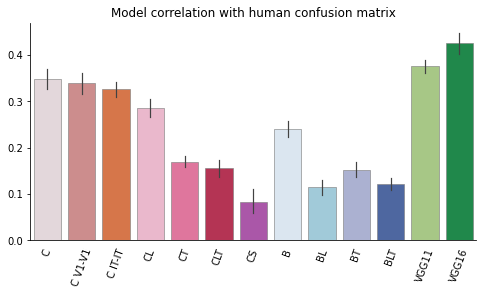

In [71]:
# make the model confusion matrix correlation barplot
# this graph is made vertically in the paper. it's horizontal here for more readability
fig, axes = plt.subplots(1, 1, figsize = (8, 4))
axes.locator_params(axis = 'y', nbins=5)

# make the barplot
corr_plot = sns.barplot(
    data = seed_corr_df,
    ax = axes,
    palette = models_palette,
    order = models,
    errwidth = 1.2,
)
for bar in corr_plot.patches:
    bar.set_linewidth(0.6)
    bar.set_edgecolor('gray')
# corr_plot.set(ylabel = None, xlabel = None, yticks = None)
axes.set_xticklabels(models_names.values(), rotation = 70)
plt.tick_params(left = True, bottom=False)

# give a title to the plot
plt.title('Model correlation with human confusion matrix')

# remove the top and right axes
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


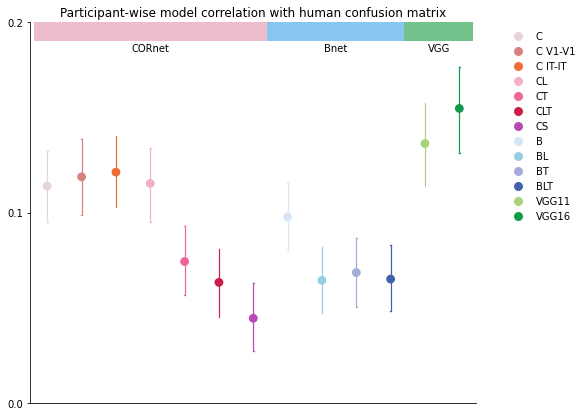

In [55]:
# plot the participant-wise model CM correlation
fig, ax = plt.subplots(1, 1, figsize = (8, 7))
plt.locator_params(axis = 'y', nbins=2)

# declare some annotation details to draw model bars on top of the graph
height = 0.01
cornets = {'x_start': -0.4, 'width': 6.8, 'colour': '#EAADC1', 'text': 'CORnet'}
bnets = {'x_start': 6.4, 'width': 4.0, 'colour': '#6CBAEF', 'text': 'Bnet'}
vggs = {'x_start': 10.4, 'width': 2.0, 'colour': '#53B46F', 'text': 'VGG'}

# make the point plot
pointplot = sns.pointplot(
    data = pd.DataFrame(corrdict),
    ax = ax,
    palette = models_palette,
    join = False,
    errwidth = 1.2,
    capsize = 0.02,
    errorbar=('ci', 95),
)
# set the axes
plt.xticks(rotation = 70)
ax.set_ylim(0.0, 0.2)
ax.set_xticklabels([])
ax.set_xticks([])

# add coloured rectangles
y_start = max(ax.get_ylim()) - 0.01 # find the y coordinate to set the bars
for family in [cornets, bnets, vggs]:
    ax.add_patch(patches.Rectangle(
        (family['x_start'], y_start), family['width'], height,
        facecolor = family['colour'],
        fill=True,
        alpha = 0.8,
        clip_on = False)
    )
    ax.annotate(
        family['text'], # family name
        (np.mean([family['x_start'], family['x_start']+family['width']]), y_start - 0.005), # in the middle of the range
        annotation_clip = False,
        ha='center',
    )
    
# add a legend with model colour
legend_handles = []
for model in models_names:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=models_palette[model], markersize=10, label=models_names[model]))

# add the legend with custom handles
ax.legend(handles=legend_handles, frameon = False, bbox_to_anchor=(1.05, 1))

# give a title to the plot
plt.title('Participant-wise model correlation with human confusion matrix')

# remove the top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)